# Applying XID+SED to Extreme Starbursts
In this notebook, we read in the data files and prepare them for fitting with XID+SED, the SED prior model extension to XID+. Here we focus on the source `HELP_J104631.170+591036.829`. This source is in [Rowan-Robinson et al. 2018](https://arxiv.org/abs/1704.07783) and claimed to have a star formation rate of $> 10^{10}\mathrm{M_{\odot}yr^{-1}}$

Import required modules

In [1]:
from astropy.io import ascii, fits
from astropy.table import Table
import pylab as plt
%matplotlib inline
from astropy import wcs


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Set image and catalogue filenames

In [2]:
#Folder containing maps

pswfits='/Volumes/pdh_storage/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/Lockman-SWIRE_SPIRE250_v1.0.fits'#SPIRE 250 map
pmwfits='/Volumes/pdh_storage/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/Lockman-SWIRE_SPIRE350_v1.0.fits'#SPIRE 350 map
plwfits='/Volumes/pdh_storage//dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/Lockman-SWIRE_SPIRE500_v1.0.fits'#SPIRE 500 map




#output folder
output_folder='./'

Load in images, noise maps, header info and WCS information

In [3]:
#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header

im250=hdulist[1].data*1.0E3 #convert to mJy
nim250=hdulist[3].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist[1].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist[1].header

im350=hdulist[1].data*1.0E3 #convert to mJy
nim350=hdulist[3].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist[1].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist[1].header 
im500=hdulist[1].data*1.0E3 #convert to mJy
nim500=hdulist[3].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist[1].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

XID+ uses Multi Order Coverage (MOC) maps for cutting down maps and catalogues so they cover the same area. It can also take in MOCs as selection functions to carry out additional cuts. Lets use the python module [pymoc](http://pymoc.readthedocs.io/en/latest/) to create a MOC, centered on a specific position we are interested in. We will use a HEALPix order of 15 (the resolution: higher order means higher resolution)

Read in the source we are interested in from Rowan-Robinsons's catalogue.

In [4]:
ysb=Table.read('../../../data/MRRfiles/fromPaper.txt', format='ascii')

In [5]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import os

c = SkyCoord(ra=[ysb['RA'][32]]*u.degree, dec=[ysb['dec'][32]]*u.degree)

import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,100,15)

Load in catalogue you want to fit (and make any cuts). Here we use HELP's VO database and directly call it using PyVO

In [6]:
import pyvo as vo
service = vo.dal.TAPService("https://herschel-vos.phys.sussex.ac.uk/__system__/tap/run/tap")

In [7]:
resultset = service.search("SELECT TOP 10000 * FROM herschelhelp.main WHERE 1=CONTAINS(POINT('ICRS', ra, dec),CIRCLE('ICRS',"+str(c.ra.deg[0])+", "+str(c.dec.deg[0])+", 0.028 ))")

In [8]:
masterlist=resultset.table

In [9]:
masterlist

<Table length=779>
    field               help_id           ... flag_optnir_obs flag_optnir_det
                                          ...                                
    object               object           ...      int16           int16     
------------- --------------------------- ... --------------- ---------------
Lockman SWIRE HELP_J104641.800+591134.329 ...               7               1
Lockman SWIRE HELP_J104642.298+591129.334 ...               7               5
Lockman SWIRE HELP_J104642.773+591122.819 ...               7               5
Lockman SWIRE HELP_J104643.184+591114.597 ...               7               7
Lockman SWIRE HELP_J104642.697+591110.431 ...               7               5
Lockman SWIRE HELP_J104643.626+591102.446 ...               7               1
Lockman SWIRE HELP_J104643.318+591100.617 ...               7               1
Lockman SWIRE HELP_J104643.761+591048.844 ...               7               4
Lockman SWIRE HELP_J104644.286+591042.028 ...               7               4
          ...                         ... ...             ...             ...
Lockman SWIRE HELP_J104623.154+590939.857 ...               7               1
Lockman SWIRE HELP_J104621.476+590941.351 ...               7               1
Lockman SWIRE HELP_J104620.821+590936.898 ...               7               1
Lockman SWIRE HELP_J104621.755+590934.681 ...               7               1
Lockman SWIRE HELP_J104623.619+590935.614 ...               7               1
Lockman SWIRE HELP_J104623.136+590934.412 ...               7               0
Lockman SWIRE HELP_J104622.426+590932.574 ...               7               1
Lockman SWIRE HELP_J104623.326+590931.630 ...               7               5
Lockman SWIRE HELP_J104623.554+590930.911 ...               7               1
Lockman SWIRE HELP_J104623.029+590920.085 ...               7               1

In [10]:
masterlist['help_id']

<MaskedColumn name='help_id' dtype='object' description='HELP identifier, based on J2000 position' length=779>
HELP_J104641.800+591134.329
HELP_J104642.298+591129.334
HELP_J104642.773+591122.819
HELP_J104643.184+591114.597
HELP_J104642.697+591110.431
HELP_J104643.626+591102.446
HELP_J104643.318+591100.617
HELP_J104643.761+591048.844
HELP_J104644.286+591042.028
HELP_J104632.384+591215.934
HELP_J104630.583+591211.071
HELP_J104630.684+591210.137
                        ...
HELP_J104623.180+590943.550
HELP_J104622.434+590944.268
HELP_J104623.154+590939.857
HELP_J104621.476+590941.351
HELP_J104620.821+590936.898
HELP_J104621.755+590934.681
HELP_J104623.619+590935.614
HELP_J104623.136+590934.412
HELP_J104622.426+590932.574
HELP_J104623.326+590931.630
HELP_J104623.554+590930.911
HELP_J104623.029+590920.085

## Filter table
We will only use objects that are not stars (i.e. have `flag_gaia` = 3)

In [11]:
prior_list=masterlist[(masterlist['flag_gaia']!=3) & (masterlist['flag_optnir_det']>=3)]

## Get Redshift and Uncertianty


Ken Duncan defines a median and a hierarchical bayes combination redshift. We need uncertianty so lets match via `help_id`

In [12]:
photoz=Table.read("/Volumes/pdh_storage/dmu_products/dmu24/dmu24_Lockman-SWIRE/data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised_UPDATED_IDs_20180219.fits")

In [13]:
help_id=np.empty((len(photoz)),dtype=np.dtype('U27'))
for i in range(0,len(photoz)):
    help_id[i]=photoz['help_id'][i].strip()
photoz['help_id']=help_id

In [14]:
from astropy.table import Column, MaskedColumn
prior_list['redshift']=MaskedColumn(np.full((len(prior_list)),fill_value=3.0),mask=[True]*len(prior_list))
prior_list.add_column(MaskedColumn(np.full((len(prior_list)),fill_value=3.0),mask=[True]*len(prior_list),name='redshift_unc'))

In [15]:
ii=0
for i in range(0,len(prior_list)):
    ind=photoz['help_id'] == prior_list['help_id'][i]
    try:
        prior_list['redshift'][i]=photoz['z1_median'][ind]
        prior_list['redshift_unc'][i]=np.max(np.array([np.abs(photoz['z1_median'][ind]-photoz['z1_min'][ind]),np.abs(photoz['z1_max'][ind]-photoz['z1_median'][ind])]))
        prior_list['redshift_unc'].mask[i]=False
        prior_list['redshift'].mask[i]=False

    except ValueError:
        None

In [16]:
prior_list[prior_list['redshift'].mask == False]

<Table length=177>
    field               help_id           ...     redshift_unc    
                                          ...                     
    object               object           ...       float64       
------------- --------------------------- ... --------------------
Lockman SWIRE HELP_J104642.298+591129.334 ...               0.7119
Lockman SWIRE HELP_J104642.773+591122.819 ...   0.6596000000000002
Lockman SWIRE HELP_J104643.184+591114.597 ...  0.05360000000000001
Lockman SWIRE HELP_J104642.697+591110.431 ...  0.23040000000000005
Lockman SWIRE HELP_J104633.946+591207.871 ...               0.5483
Lockman SWIRE HELP_J104635.341+591207.249 ...   0.3524999999999999
Lockman SWIRE HELP_J104635.772+591203.515 ...   0.9684000000000001
Lockman SWIRE HELP_J104638.221+591148.656 ...  0.35700000000000004
Lockman SWIRE HELP_J104633.388+591159.665 ...               0.5299
          ...                         ... ...                  ...
Lockman SWIRE HELP_J104632.850+590927.518 ...               0.1311
Lockman SWIRE HELP_J104628.984+590922.830 ...               0.3708
Lockman SWIRE HELP_J104628.783+590920.883 ...  0.15120000000000022
Lockman SWIRE HELP_J104628.294+590913.733 ... 0.051000000000000004
Lockman SWIRE HELP_J104626.064+590921.433 ...  0.23839999999999995
Lockman SWIRE HELP_J104626.000+590920.911 ...   0.2316999999999999
Lockman SWIRE HELP_J104630.585+590903.610 ...               0.5563
Lockman SWIRE HELP_J104627.623+590904.708 ...  0.26759999999999995
Lockman SWIRE HELP_J104620.766+590941.855 ...   0.5698999999999999
Lockman SWIRE HELP_J104623.326+590931.630 ...               0.5871

## Add additional source
The fit appears bad and requires another source. There appears to be a suitable one in masterlist so lets add it with redshift 3 and uncertianty 3.

In [17]:
z_sig_new=3
prior_list['redshift'].mask[prior_list['help_id']=='HELP_J104631.170+591036.829']=False
prior_list['redshift_unc'].mask[prior_list['help_id']=='HELP_J104631.170+591036.829']=False
prior_list=prior_list[prior_list['redshift'].mask == False]

In [18]:
prior_list

<Table length=177>
    field               help_id           ...     redshift_unc    
                                          ...                     
    object               object           ...       float64       
------------- --------------------------- ... --------------------
Lockman SWIRE HELP_J104642.298+591129.334 ...               0.7119
Lockman SWIRE HELP_J104642.773+591122.819 ...   0.6596000000000002
Lockman SWIRE HELP_J104643.184+591114.597 ...  0.05360000000000001
Lockman SWIRE HELP_J104642.697+591110.431 ...  0.23040000000000005
Lockman SWIRE HELP_J104633.946+591207.871 ...               0.5483
Lockman SWIRE HELP_J104635.341+591207.249 ...   0.3524999999999999
Lockman SWIRE HELP_J104635.772+591203.515 ...   0.9684000000000001
Lockman SWIRE HELP_J104638.221+591148.656 ...  0.35700000000000004
Lockman SWIRE HELP_J104633.388+591159.665 ...               0.5299
          ...                         ... ...                  ...
Lockman SWIRE HELP_J104632.850+590927.518 ...               0.1311
Lockman SWIRE HELP_J104628.984+590922.830 ...               0.3708
Lockman SWIRE HELP_J104628.783+590920.883 ...  0.15120000000000022
Lockman SWIRE HELP_J104628.294+590913.733 ... 0.051000000000000004
Lockman SWIRE HELP_J104626.064+590921.433 ...  0.23839999999999995
Lockman SWIRE HELP_J104626.000+590920.911 ...   0.2316999999999999
Lockman SWIRE HELP_J104630.585+590903.610 ...               0.5563
Lockman SWIRE HELP_J104627.623+590904.708 ...  0.26759999999999995
Lockman SWIRE HELP_J104620.766+590941.855 ...   0.5698999999999999
Lockman SWIRE HELP_J104623.326+590931.630 ...               0.5871

### Remove HELP_J104631.082+591021.253
As a comparison model, lets remove `HELP_J104631.082+591021.253` such that the flux is only going to HELP_J104631.170+591036.829. This will indicate if this is feasible, given the data.

In [19]:
#prior_list['redshift'].mask[prior_list['help_id']=='HELP_J104631.082+591021.253']=True
#prior_list=prior_list[prior_list['redshift'].mask == False]

XID+ is built around two python classes. A prior and posterior class. There should be a prior class for each map being fitted. It is initiated with a map, noise map, primary header and map header and can be set with a MOC. It also requires an input prior catalogue and point spread function.


In [20]:
#---prior250--------
#prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
#prior250.prior_cat(prior_list['ra'],prior_list['dec'],'photoz', z_median=prior_list['redshift']._get_data(), z_sig=prior_list['redshift_unc']._get_data(),ID=prior_list['help_id'])#Set input catalogue
#prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
#prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=moc)
#prior350.prior_cat(prior_list['ra'],prior_list['dec'],'photoz', z_median=prior_list['redshift']._get_data(), z_sig=prior_list['redshift_unc']._get_data(),ID=prior_list['help_id'])
#prior350.prior_bkg(-5.0,5)

#---prior500--------
#prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=moc)
#prior500.prior_cat(prior_list['ra'],prior_list['dec'],'photoz', z_median=prior_list['redshift']._get_data(), z_sig=prior_list['redshift_unc']._get_data(),ID=prior_list['help_id'])
#prior500.prior_bkg(-5.0,5)

In [21]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(prior_list['ra'],prior_list['dec'],'photoz',ID=prior_list['help_id'])
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=moc)
prior350.prior_cat(prior_list['ra'],prior_list['dec'],'photoz',ID=prior_list['help_id'])
prior350.prior_bkg(-5.0,5)
#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=moc)
prior500.prior_cat(prior_list['ra'],prior_list['dec'],'photoz',ID=prior_list['help_id'])
prior500.prior_bkg(-5.0,5)

Set PSF. For SPIRE, the PSF can be assumed to be Gaussian with a FWHM of 18.15, 25.15, 36.3 '' for 250, 350 and 500 $\mathrm{\mu m}$ respectively. Lets use the astropy module to construct a Gaussian PSF and assign it to the three XID+ prior classes.

In [22]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [23]:
print('fitting '+ str(prior250.nsrc)+' sources \n')
print('using ' +  str(prior250.snpix)+', '+ str(prior350.snpix)+' and '+ str(prior500.snpix)+' pixels')
print('source density = {}'.format(prior250.nsrc/moc.area_sq_deg))

fitting 174 sources 

using 859, 447 and 213 pixels
source density = 71887.50981612627


Before fitting, the prior classes need to take the PSF and calculate how muich each source contributes to each pixel. This process provides what we call a pointing matrix. Lets calculate the pointing matrix for each prior class

In [24]:
prior250.get_pointing_matrix()
prior350.get_pointing_matrix()
prior500.get_pointing_matrix()


### Set SED priors
Now lets set the SED priors. Note redshift and temperature need to be transformed into log10. To get the appropriate prior uncertianty, I will use:
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/e5a771330b5db50ddce6342c2932604ef0afad23)
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/fc9f7d8cc90a45d4802860f27d2911b09bf4a8a5)

In [25]:
z_mu=np.empty((prior250.nsrc))
z_sig=np.empty((prior250.nsrc))
for x,i in enumerate(prior250.ID):
    ind=prior_list['help_id']==i
    z_mu[x]=prior_list['redshift'][ind]
    z_sig[x]=prior_list['redshift_unc'][ind]

In [26]:

lir_mu=np.full(prior250.nsrc,11)
lir_sig=np.full(prior250.nsrc,1)

t_mu=np.full(prior250.nsrc,40.0)
t_sig=np.full(prior250.nsrc,0.5)

In [27]:
params_mu=np.vstack((lir_mu,z_mu,t_mu)).T
params_sig=np.vstack((lir_sig,z_sig,t_sig)).T
params_names=['L_ir','z','Temp']
emulator_path='/Users/pdh21/Google_Drive/WORK/XID_plus/docs/notebooks/examples/SED_emulator/GB_emulator_20210324_notlog10z_T.pkl'

In [28]:
class hier_prior(object):
    def __init__(self,ID,params_mu,params_sig,params_names,emulator_path):
        """Initiate SED prior class
        
        :param params_mu array with mean values of parameters
        :param params_sig array with sigma values of parameters
        :param params_names list of names of params
        :param emulator_path path to saved emulator file"""
        
        from astropy.table import Table, join
        from xidplus.numpyro_fit.misc import load_emulator
        mu_table=Table(params_mu,names=[i+'_mu' for i in params_names])
        sig_table=Table(params_sig,names=[i+'_sig' for i in params_names])
        
        mu_table.add_column(ID, name='ID')
        sig_table.add_column(ID, name='ID')
        
        self.prior_table=join(mu_table,sig_table,keys='ID')
        
        self.emulator=load_emulator(emulator_path)
        #transform parameters into standardised parameters
        self.params_mu=self.emulator['transform_parameters'](params_mu.T)
        #as prior is normal transform mu+sigma then subtract transformed mu
        self.params_sig=self.emulator['transform_parameters'](params_mu.T+params_sig.T)-self.params_mu

In [29]:
phys_prior=hier_prior(prior250.ID,params_mu,params_sig,params_names,emulator_path)

W0326 17:13:12.906318 4604112320 xla_bridge.py:135] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [30]:
phys_prior.emulator['transform_parameters'](np.array([0.0,0.0,0.0]))

DeviceArray([[-3.8105116, -1.7320508, -2.8867512]], dtype=float32)

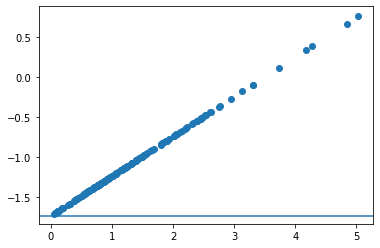

In [31]:
plt.plot(z_mu,phys_prior.params_mu[:,1],'o')
plt.axhline(-1.73)

## Generate Prior Predictive Distribtion

In [32]:
from numpyro.infer import Predictive
from jax import random, vmap
from xidplus.numpyro_fit import SED_prior

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [33]:
## FOr numpyro to sample from the prior, the data needs to be set to None
priors=[prior250,prior350,prior500]
import copy
#make a deepcopy of the priors
priors_prior_pred=copy.deepcopy(priors)
#set data to None
for i in range(0,3):
    priors_prior_pred[i].sim=None

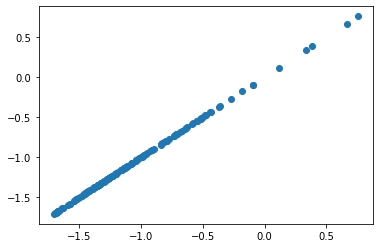

In [34]:
plt.plot(phys_prior.params_mu[:,1],1*phys_prior.params_mu[:,1]+0,'o')

In [35]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer.reparam import TransformReparam
import jax.numpy as jnp
from jax import random
import numpy as np
import jax
import pickle
import os
from xidplus.numpyro_fit.misc import sp_matmul, load_emulator

numpyro.set_host_device_count(os.cpu_count())

def spire_model(priors,sed_prior):
    pointing_matrices = [([p.amat_row, p.amat_col], p.amat_data) for p in priors]


    bkg_mu= np.asarray([p.bkg[0] for p in priors]).T
    bkg_sig = np.asarray([p.bkg[1] for p in priors]).T
    #lir_mu=numpyro.sample('lir_mu',dist.Normal(10,1))
    #lir_sig=numpyro.sample('lir_sig',dist.HalfCauchy(1,0.5))

    #params_mu=sed_prior.params_mu
    #params_mu[:,0]=lir_mu
    #params_sig=sed_prior.params_sig
    #params_sig[:,0]=lir_sig
    with numpyro.plate('bands', len(priors)):

        #sigma_conf = numpyro.sample('sigma_conf', dist.HalfCauchy(1,0.5))
        bkg = numpyro.sample('bkg', dist.Normal(bkg_mu,bkg_sig))


    with numpyro.plate('n_param', 3):
        with numpyro.plate('nsrc', priors[0].nsrc):
            with numpyro.handlers.reparam(config={"params":TransformReparam()}):
                
                params = numpyro.sample('params', dist.TransformedDistribution(dist.Normal(0.0,1.0),dist.transforms.AffineTransform(sed_prior.params_mu,sed_prior.params_sig)))
        #sfr=numpyro.sample('sfr',dist.Normal(sed_prior.params_mu[:,0],sed_prior.params_sig[:,0]))
        #agn_frac=numpyro.sample('agn_frac',dist.Normal(sed_prior.params_mu[:,1],sed_prior.params_sig[:,1]))
        #redshift=numpyro.sample('redshift',dist.Normal(sed_prior.params_mu[:,2],sed_prior.params_sig[:,2]))

    #params = jnp.vstack((sfr[None,:],agn_frac[None,:],redshift[None,:])).T

    src_f=jnp.exp(sed_prior.emulator['net_apply'](sed_prior.emulator['params'],params))

    #src_f = numpyro.sample('src_f', dist.(flux_lower, flux_upper))
    db_hat_psw = sp_matmul(pointing_matrices[0], src_f[:, 0][:, None], priors[0].snpix).reshape(-1) + bkg[0]
    db_hat_pmw = sp_matmul(pointing_matrices[1], src_f[:, 1][:, None], priors[1].snpix).reshape(-1) + bkg[1]
    db_hat_plw = sp_matmul(pointing_matrices[2], src_f[:, 2][:, None], priors[2].snpix).reshape(-1) + bkg[2]

    #sigma_tot_psw = jnp.sqrt(jnp.power(priors[0].snim, 2) + jnp.power(sigma_conf[0], 2))
    #sigma_tot_pmw = jnp.sqrt(jnp.power(priors[1].snim, 2) + jnp.power(sigma_conf[1], 2))
    #sigma_tot_plw = jnp.sqrt(jnp.power(priors[2].snim, 2) + jnp.power(sigma_conf[2], 2))


    with numpyro.plate('psw_pixels', priors[0].snim.size):  # as ind_psw:
        numpyro.sample("obs_psw", dist.Normal(db_hat_psw,priors[0].snim ),
                                 obs=priors[0].sim)
    with numpyro.plate('pmw_pixels', priors[1].snim.size):  # as ind_pmw:
        numpyro.sample("obs_pmw", dist.Normal(db_hat_pmw, priors[1].snim),
                                 obs=priors[1].sim)
    with numpyro.plate('plw_pixels', priors[2].snim.size):  # as ind_plw:
        numpyro.sample("obs_plw", dist.Normal(db_hat_plw, priors[2].snim),
                                 obs=priors[2].sim)
        
def spire_model_trunc(priors,sed_prior):
    pointing_matrices = [([p.amat_row, p.amat_col], p.amat_data) for p in priors]

    bkg_mu= np.asarray([p.bkg[0] for p in priors]).T
    bkg_sig = np.asarray([p.bkg[1] for p in priors]).T
    #lir_mu=numpyro.sample('lir_mu',dist.Normal(10,1))
    #lir_sig=numpyro.sample('lir_sig',dist.HalfCauchy(1,0.5))

    #params_mu=sed_prior.params_mu
    #params_mu[:,0]=lir_mu
    #params_sig=sed_prior.params_sig
    #params_sig[:,0]=lir_sig
    with numpyro.plate('bands', len(priors)):

        #sigma_conf = numpyro.sample('sigma_conf', dist.HalfCauchy(1,0.5))
        bkg = numpyro.sample('bkg', dist.Normal(bkg_mu,bkg_sig))

    m=numpyro.sample('m',dist.Normal(1,0.5))
    c=numpyro.sample('c',dist.Normal(-1,0.5))
  
    lir_sig=numpyro.sample('lir_sig',dist.HalfNormal(0.5))

    with numpyro.plate('nsrc', priors[0].nsrc):
        redshift = numpyro.sample('redshift',dist.TruncatedNormal(-1.732,sed_prior.params_mu[:,1],sed_prior.params_sig[:,1]))

        with numpyro.handlers.reparam(config={"params":TransformReparam()}):
                
            lir = numpyro.sample('lir', dist.TransformedDistribution(dist.Normal(0.0,1.0),dist.transforms.AffineTransform(redshift*m+c,jnp.full(priors[0].nsrc,lir_sig))))
            temp = numpyro.sample('temp', dist.TransformedDistribution(dist.Normal(0.0,1.0),dist.transforms.AffineTransform(sed_prior.params_mu[:,2],sed_prior.params_sig[:,2])))
        #sfr=numpyro.sample('sfr',dist.Normal(sed_prior.params_mu[:,0],sed_prior.params_sig[:,0]))
        #agn_frac=numpyro.sample('agn_frac',dist.Normal(sed_prior.params_mu[:,1],sed_prior.params_sig[:,1]))
        #redshift=numpyro.sample('redshift',dist.Normal(sed_prior.params_mu[:,2],sed_prior.params_sig[:,2]))

    params = jnp.vstack((lir[None,:],redshift[None,:],temp[None,:])).T

    src_f=jnp.exp(sed_prior.emulator['net_apply'](sed_prior.emulator['params'],params))

    #src_f = numpyro.sample('src_f', dist.(flux_lower, flux_upper))
    db_hat_psw = sp_matmul(pointing_matrices[0], src_f[:, 0][:, None], priors[0].snpix).reshape(-1) + bkg[0]
    db_hat_pmw = sp_matmul(pointing_matrices[1], src_f[:, 1][:, None], priors[1].snpix).reshape(-1) + bkg[1]
    db_hat_plw = sp_matmul(pointing_matrices[2], src_f[:, 2][:, None], priors[2].snpix).reshape(-1) + bkg[2]

    #sigma_tot_psw = jnp.sqrt(jnp.power(priors[0].snim, 2) + jnp.power(sigma_conf[0], 2))
    #sigma_tot_pmw = jnp.sqrt(jnp.power(priors[1].snim, 2) + jnp.power(sigma_conf[1], 2))
    #sigma_tot_plw = jnp.sqrt(jnp.power(priors[2].snim, 2) + jnp.power(sigma_conf[2], 2))


    with numpyro.plate('psw_pixels', priors[0].snim.size):  # as ind_psw:
        numpyro.sample("obs_psw", dist.Normal(db_hat_psw,priors[0].snim ),
                                 obs=priors[0].sim)
    with numpyro.plate('pmw_pixels', priors[1].snim.size):  # as ind_pmw:
        numpyro.sample("obs_pmw", dist.Normal(db_hat_pmw, priors[1].snim),
                                 obs=priors[1].sim)
    with numpyro.plate('plw_pixels', priors[2].snim.size):  # as ind_plw:
        numpyro.sample("obs_plw", dist.Normal(db_hat_plw, priors[2].snim),
                                 obs=priors[2].sim)


In [36]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive=Predictive(spire_model_trunc,posterior_samples = {}, num_samples = 50,)
prior_pred=prior_predictive(random.PRNGKey(0),priors_prior_pred,phys_prior)

CPU times: user 12 s, sys: 311 ms, total: 12.3 s
Wall time: 15.6 s


In [37]:
#Create a list of the model map arrays
mod_map_array=[prior_pred['obs_psw'].T,prior_pred['obs_pmw'].T,prior_pred['obs_plw'].T]

In [38]:
#feed the model map arrays the animation function
xidplus.plots.make_map_animation(priors,mod_map_array,50)

In [39]:
params = jnp.stack((prior_pred['lir'].T,prior_pred['redshift'].T,prior_pred['temp'].T)).T
trans_params=phys_prior.emulator['inverse_transform_parameters'](params)
src_f_2=np.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'],params))


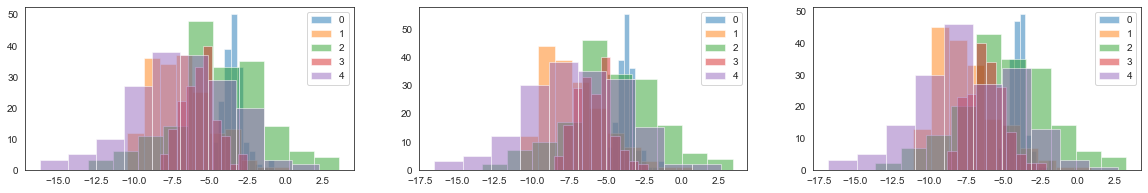

In [124]:
fig,axes=plt.subplots(1,src_f_2.shape[-1],figsize=(20,src_f_2.shape[-1]))
for j in range(0,src_f_2.shape[-1]):
    for i in range(0,5):
        axes[j].hist(np.log10(src_f_2[i,:,j]),label=str(i),alpha=0.5)
    axes[j].legend()

In [109]:
src_f_2.shape

(50, 174, 3)

## Fit the simulated observations
To check whether `numpyro` can fit accurately, we will fit some of the prior predictive samples

In [42]:
from numpyro.diagnostics import summary
import jax.numpy as jnp
import os
numpyro.set_host_device_count(os.cpu_count())
from operator import attrgetter
num_samp=1
all_samples=[]
all_stats=[]
all_divergences=[]
for s in [4]:
    #make a deepcopy of the priors
    priors_prior_pred_samp=copy.deepcopy(priors)
    #set data to sample data
    for i in range(0,3):
        priors_prior_pred_samp[i].sim=mod_map_array[i][:,s]
    nuts_kernel = NUTS(spire_model_trunc,init_strategy=numpyro.infer.init_to_median())
    mcmc = MCMC(nuts_kernel, num_samples=500, num_warmup=500,num_chains=2)
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key,priors_prior_pred_samp,phys_prior)
    all_samples.append(mcmc.get_samples())
    all_divergences.append(mcmc.get_extra_fields()['diverging'])
    prob = 0.9
    exclude_deterministic = True
    sites = mcmc._states[mcmc._sample_field]
    if isinstance(sites, dict) and exclude_deterministic:
        state_sample_field = attrgetter(mcmc._sample_field)(mcmc._last_state)
        # XXX: there might be the case that state.z is not a dictionary but
        # its postprocessed value `sites` is a dictionary.
        # TODO: in general, when both `sites` and `state.z` are dictionaries,
        # they can have different key names, not necessary due to deterministic
        # behavior. We might revise this logic if needed in the future.
        if isinstance(state_sample_field, dict):
            sites = {k: v for k, v in mcmc._states[mcmc._sample_field].items()
                     if k in state_sample_field}

    stats_summary = summary(sites, prob=prob)
    all_stats.append(stats_summary)
  

sample: 100%|██████████| 1000/1000 [03:18<00:00,  5.04it/s, 127 steps of size 3.00e-02. acc. prob=0.94]


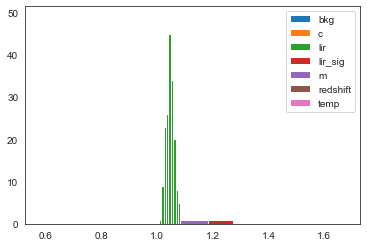

In [318]:
[plt.hist(all_stats[0][i]['r_hat'],label=i) for i in all_stats[0]]
plt.legend()

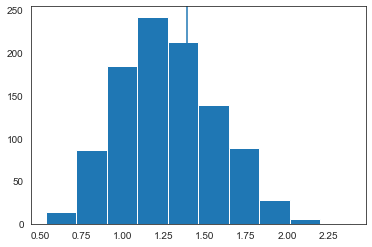

In [320]:
plt.hist(all_samples[0]['m'])
plt.axvline(prior_pred['m'][4])

In [61]:
params_fit = jnp.stack((all_samples[0]['lir'].T,all_samples[0]['redshift'].T,all_samples[0]['temp'].T)).T
print(params_fit.shape)
src_f_fit=np.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'],params_fit))

(1000, 174, 3)


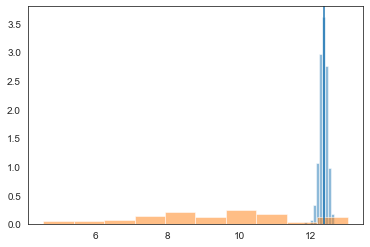

In [323]:
src=17
p=0
plt.hist(phys_prior.emulator['inverse_transform_parameters'](params_fit)[:,src,p],alpha=0.5,normed=True)
plt.hist(trans_params[:,src,p],normed=True,alpha=0.5)
plt.axvline(trans_params[4,src,p])

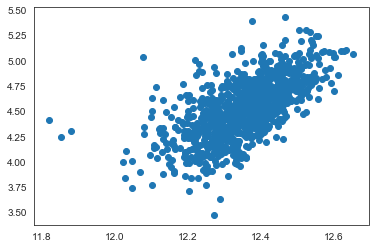

In [324]:
plt.plot(phys_prior.emulator['inverse_transform_parameters'](params_fit)[:,src,0],phys_prior.emulator['inverse_transform_parameters'](params_fit)[:,src,1],'o')

In [325]:
np.mean(src_f_fit[:,:,0],axis=0)>1

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

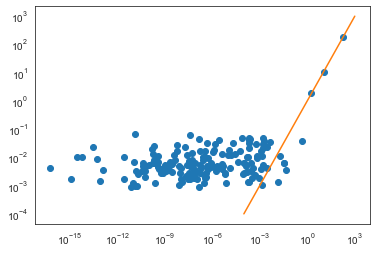

In [326]:
plt.loglog(src_f_2[4,:,0],np.mean(src_f_fit[:,:,0],axis=0),'o')
plt.plot(np.arange(0.0001,1000),np.arange(0.0001,1000))

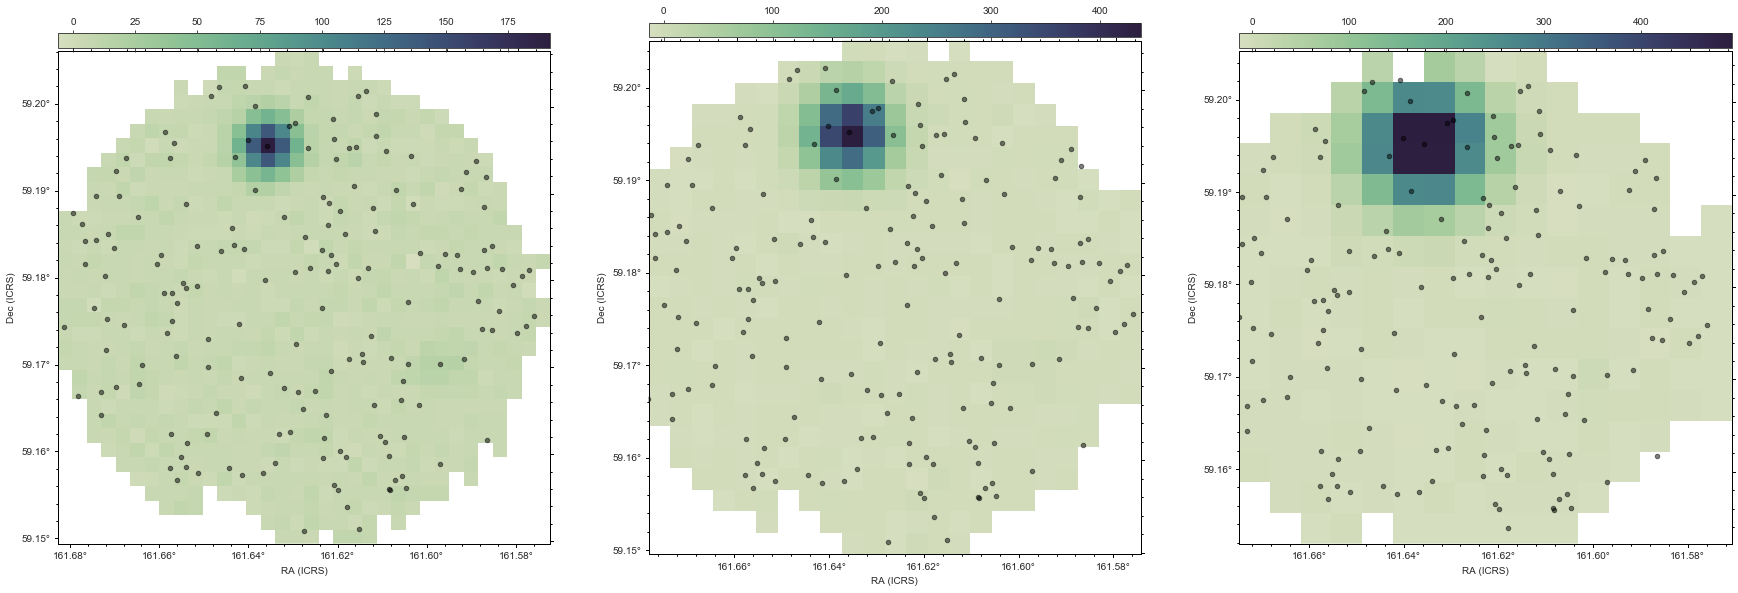

In [246]:
figures,fig=xidplus.plot_map(priors_prior_pred_samp)

In [252]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive_fit=Predictive(spire_model_trunc,posterior_samples = all_samples[0], num_samples = 50,)
prior_pred_fit=prior_predictive_fit(random.PRNGKey(0),priors_prior_pred,phys_prior)
mod_map_array_fit=[prior_pred_fit['obs_psw'].T,prior_pred_fit['obs_pmw'].T,prior_pred_fit['obs_plw'].T]

CPU times: user 2.92 s, sys: 82.8 ms, total: 3.01 s
Wall time: 3.42 s


In [254]:
#feed the model map arrays the animation function
xidplus.plots.make_map_animation(priors_prior_pred_samp,mod_map_array_fit,50)

## Can it fit actual data?

In [88]:
warnings.simplefilter("ignore")  # turn warnings to errors

nuts_kernel = NUTS(spire_model_trunc,init_strategy=numpyro.infer.init_to_median())
mcmc = MCMC(nuts_kernel, num_samples=500, num_warmup=500,num_chains=2)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key,priors,phys_prior)

sample: 100%|██████████| 1000/1000 [06:44<00:00,  2.47it/s, 255 steps of size 2.25e-02. acc. prob=0.87]


In [89]:
samples=mcmc.get_samples()
divergences=mcmc.get_extra_fields()['diverging']
prob = 0.9
exclude_deterministic = True
sites = mcmc._states[mcmc._sample_field]
if isinstance(sites, dict) and exclude_deterministic:
    state_sample_field = attrgetter(mcmc._sample_field)(mcmc._last_state)
    # XXX: there might be the case that state.z is not a dictionary but
    # its postprocessed value `sites` is a dictionary.
    # TODO: in general, when both `sites` and `state.z` are dictionaries,
    # they can have different key names, not necessary due to deterministic
    # behavior. We might revise this logic if needed in the future.
    if isinstance(state_sample_field, dict):
        sites = {k: v for k, v in mcmc._states[mcmc._sample_field].items()
                 if k in state_sample_field}

stats_summary = summary(sites, prob=prob)


(array([0.19440713, 0.38881428, 0.87483207, 0.5832213 , 0.38881431,
        0.9720355 , 0.5832213 , 0.58322163, 0.1944071 , 0.09720355]),
 array([0.0035756 , 0.20932938, 0.41508314, 0.6208369 , 0.8265907 ,
        1.0323445 , 1.2380983 , 1.4438521 , 1.6496058 , 1.8553596 ,
        2.0611134 ], dtype=float32),
 <a list of 10 Patch objects>)

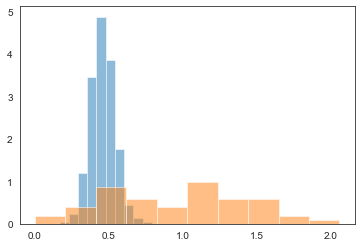

In [103]:
plt.hist(samples['m'][:],alpha=0.5,normed=True)
plt.hist(prior_pred['m'],alpha=0.5,normed=True)


(array([0.09599806, 0.09599817, 0.28799418, 0.19199623, 0.76798491,
        1.15197737, 0.6719868 , 0.28799426, 0.86398303, 0.3839924 ]),
 array([-2.26837   , -2.0600324 , -1.8516951 , -1.6433575 , -1.4350201 ,
        -1.2266827 , -1.0183452 , -0.8100078 , -0.6016703 , -0.3933329 ,
        -0.18499544], dtype=float32),
 <a list of 10 Patch objects>)

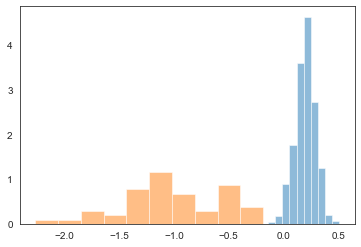

In [104]:
plt.hist(samples['c'][:],alpha=0.5,normed=True)
plt.hist(prior_pred['c'],alpha=0.5,normed=True)


(array([1.73470466, 1.59014594, 1.73470485, 0.86735224, 0.43367631,
        0.        , 0.57823482, 0.14455877, 0.        , 0.14455877]),
 array([0.03760403, 0.17595612, 0.3143082 , 0.45266026, 0.59101236,
        0.7293644 , 0.8677165 , 1.0060686 , 1.1444206 , 1.2827728 ,
        1.4211248 ], dtype=float32),
 <a list of 10 Patch objects>)

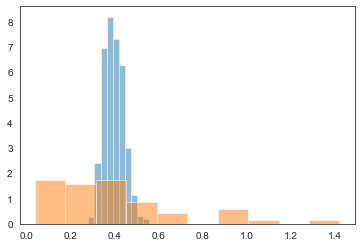

In [105]:
plt.hist(samples['lir_sig'][:],alpha=0.5,normed=True)
plt.hist(prior_pred['lir_sig'],alpha=0.5,normed=True)

(array([57., 39., 31., 19., 11.,  8.,  3.,  2.,  0.,  4.]),
 array([0.9980329 , 0.9986132 , 0.9991935 , 0.99977374, 1.000354  ,
        1.0009344 , 1.0015146 , 1.0020949 , 1.0026752 , 1.0032554 ,
        1.0038357 ], dtype=float32),
 <a list of 10 Patch objects>)

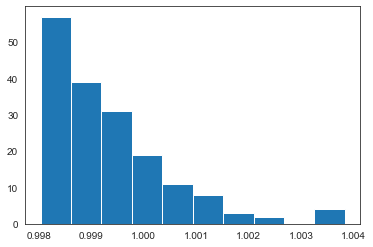

In [110]:
plt.hist(stats_summary['temp']['r_hat'])

In [113]:
%%time 
#sample from the prior using numpyro's Predictive function
predictive_fit=Predictive(spire_model_trunc,posterior_samples = samples, num_samples = 50,)
pred_fit=predictive_fit(random.PRNGKey(0),priors_prior_pred,phys_prior)
mod_map_array_fit=[pred_fit['obs_psw'].T,pred_fit['obs_pmw'].T,pred_fit['obs_plw'].T]

CPU times: user 2.35 s, sys: 57.4 ms, total: 2.41 s
Wall time: 2.72 s


In [114]:
#feed the model map arrays the animation function
xidplus.plots.make_map_animation(priors,mod_map_array_fit,50)

([<aplpy.core.FITSFigure at 0x7fa8cfbe5470>,
 <Figure size 2160x720 with 6 Axes>)

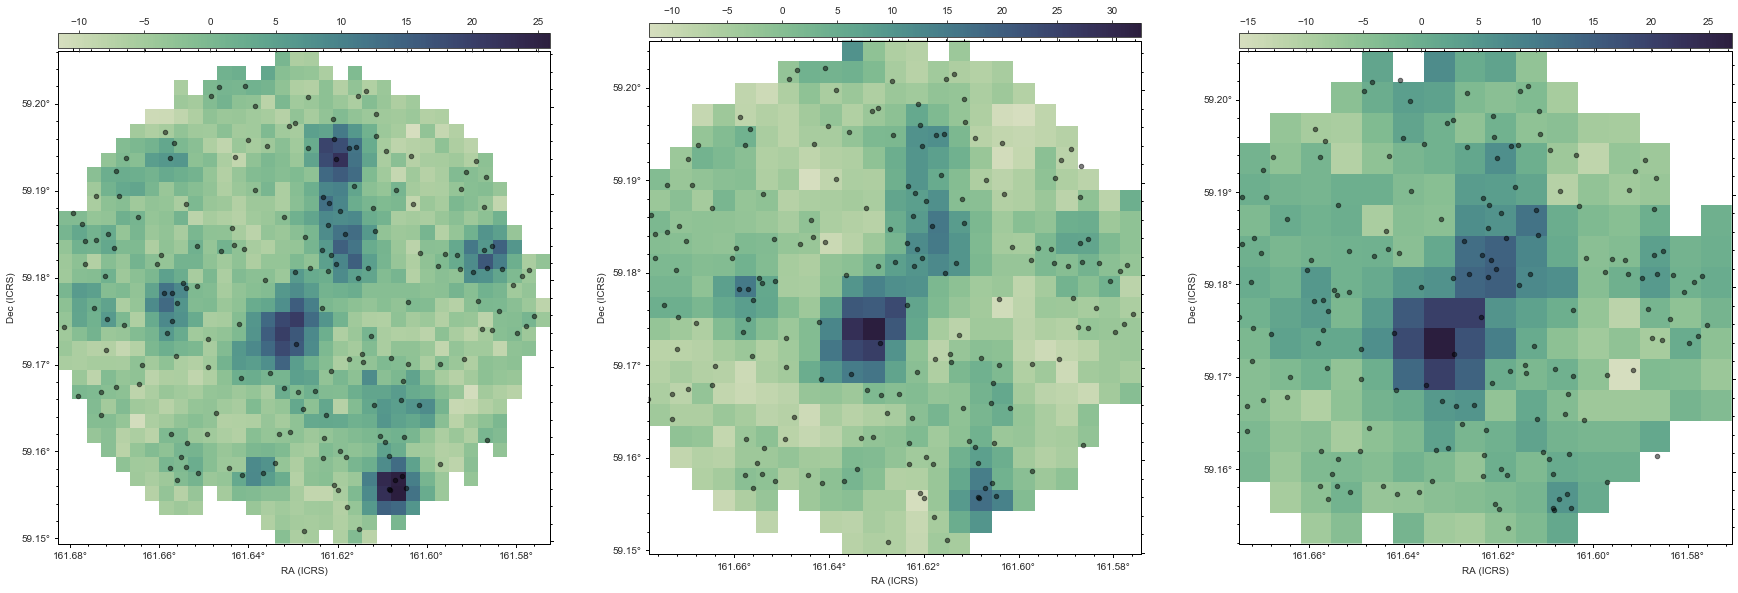

In [115]:
xidplus.plot_map(priors)

## Does VI work?

In [45]:
from numpyro.infer import SVI, Trace_ELBO, ELBO
import numpyro.optim as optim

from numpyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal,AutoLowRankMultivariateNormal

In [46]:
guide=AutoLowRankMultivariateNormal(spire_model_trunc,rank=priors[0].nsrc*3+2)
svi=SVI(spire_model_trunc,guide,optim.Adam(0.0001),Trace_ELBO(num_particles=1))

In [72]:
import sys
import warnings
from IPython.core import ultratb

warnings.simplefilter("error")  # turn warnings to errors

# activate debugger on error
sys.excepthook = ultratb.FormattedTB(mode="Verbose", color_scheme="Linux", call_pdb=1)
numpyro.enable_validation()
params,losses=svi.run(random.PRNGKey(1),200000,priors_prior_pred_samp,phys_prior)

100%|██████████| 200000/200000 [1:44:28<00:00, 31.91it/s, init loss: 27054227587072.0000, avg. loss [190001-200000]: 4186.8472]      


In [67]:
params_II,losses_II=svi.run(random.PRNGKey(1),1000,priors_prior_pred_samp,phys_prior)

100%|██████████| 1000/1000 [00:38<00:00, 25.92it/s, init loss: 27054227587072.0000, avg. loss [951-1000]: 77604010852352.0000]


In [71]:
params

{'auto_cov_factor': DeviceArray([[-0.01586808, -0.01328707, -0.00242183, ...,  0.00982869,
                0.030306  ,  0.00581114],
              [ 0.01356684,  0.00724918, -0.00520398, ...,  0.02864692,
                0.0297196 , -0.01955175],
              [ 0.00255231,  0.03452696,  0.00718116, ...,  0.02773664,
                0.02542924, -0.00992897],
              ...,
              [ 0.01409599,  0.00627087,  0.00024554, ..., -0.00641712,
               -0.0032338 ,  0.00634128],
              [-0.00024998,  0.00392994, -0.01091572, ...,  0.01605491,
               -0.00583619, -0.01609153],
              [-0.00487823, -0.00487319, -0.00504986, ..., -0.00319363,
               -0.00371588,  0.00810841]], dtype=float32),
 'auto_loc': DeviceArray([ 3.90576434e+00, -7.18266249e+00, -7.25629282e+00,
              -5.58930993e-01, -1.44682229e+00, -8.74606073e-01,
              -1.02598834e+00, -1.10381222e+00, -1.12524712e+00,
              -1.15531266e+00, -1.08522701e+00, -1.220

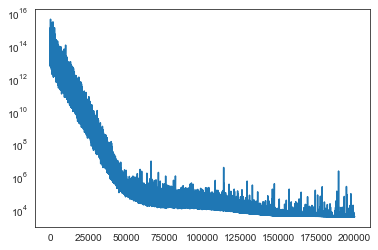

In [73]:
plt.semilogy(losses)
#plt.ylim(0,5E4)
#plt.xlim(80000,100000)

In [74]:
samples_vi=guide.sample_posterior(random.PRNGKey(1), params, (1000,))

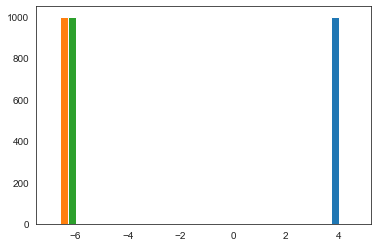

In [75]:
plt.hist(samples_vi['bkg'].T);

In [76]:
prior_pred['bkg'][s,:]

DeviceArray([ 4.517041 , -6.3878064, -6.615519 ], dtype=float32)

In [77]:
params_fit_vi = jnp.stack((samples_vi['lir'].T,samples_vi['redshift'].T,samples_vi['temp'].T)).T

In [78]:
phys_prior.emulator['inverse_transform_parameters'](params_fit_vi).shape

(1000, 174, 3)

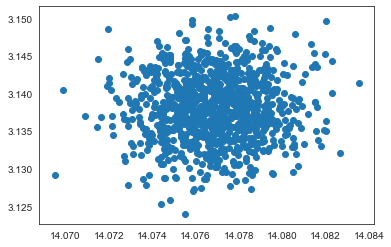

In [83]:
src=11
plt.plot(phys_prior.emulator['inverse_transform_parameters'](params_fit_vi)[:,src,0],phys_prior.emulator['inverse_transform_parameters'](params_fit_vi)[:,src,1],'o')

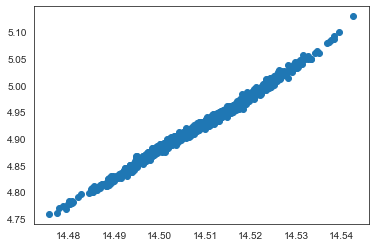

In [84]:
plt.plot(phys_prior.emulator['inverse_transform_parameters'](params_fit)[:,src,0],phys_prior.emulator['inverse_transform_parameters'](params_fit)[:,src,1],'o')

(array([ 25., 112., 150., 218., 193., 138.,  74.,  50.,  24.,  16.]),
 array([0.37365276, 0.473887  , 0.57412124, 0.6743555 , 0.7745897 ,
        0.8748239 , 0.9750582 , 1.0752925 , 1.1755266 , 1.2757609 ,
        1.3759952 ], dtype=float32),
 <a list of 10 Patch objects>)

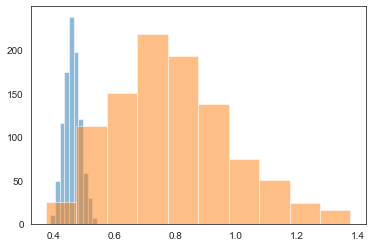

In [86]:
plt.hist(samples_vi['lir_sig'],alpha=0.5)
plt.hist(all_samples[0]['lir_sig'],alpha=0.5)